# Lab 7 Report

Prepared by Zech Wolf

## 1. Data preparation

The dataset used in this report is the Sentiment140 dataset, which consists of 1.6 million tweets. The target variable is the tweet's sentiment, on a scale of 0 (negative) to 4(positive), with 2 being neutral.


As distributed, there were some formatting issues with the CSV. I added the column names to the top of the CSV file, and used an auto-fix in VS Code to standardize the line separating characters, which were causing a problem with the Pandas read_csv function.

Dataset source: https://www.kaggle.com/datasets/kazanova/sentiment140

### 1.1 Preprocessing

The dataset needs to be cleaned up and formatted to facilitate the learning task. A few 

In [1]:
import pandas as pd

df = pd.read_csv("datasets/training.1600000.processed.noemoticon.csv")
df.target.replace(4, 1, inplace=True)

In [21]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize, WhitespaceTokenizer

stemmer = SnowballStemmer("english")
sw = set(stopwords.words("english"))

def filter(token):
    if token[0] == "@":
        return "USERNAME"
    if token.startswith(("https://","http://")):
        return "URL"
    
    return stemmer.stem(token)

ws_tok = WhitespaceTokenizer()
def process(text):
    text = " ".join([filter(w.lower()) for w in ws_tok.tokenize(text) if w not in sw])
    return text


PREPROCESS = False

if PREPROCESS:
    df["text_preprocessed"] = df.text.apply(process)
    texts = df.text_preprocessed

In [2]:
import pandas as pd

#Save or load the preprocessed text
SAVE = False
READ = True

if SAVE:
    df.text_preprocessed.to_pickle("datasets/text_preprocessed.pkl")

if READ:
    texts = pd.read_pickle("datasets/text_preprocessed.pkl")

In [3]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
seq = tokenizer.texts_to_sequences(texts)
X = pad_sequences(seq) #pad to length of longest sequence
y = df.target.to_numpy()

In [4]:
import numpy as np

print(X.shape)
print(np.max(X))

(1600000, 118)
288686


The final preprocessed datset is represented by padded sequences 118 tokens in length each. The vocabulary size is about 290,000 words

### 1.2 Train-test split

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, random_state=1234)

## 2. Modeling

Two RNN architectures are implemented with different parameters to create four different models. The models are compared to discover which architecture and parameter set performs the best.

### 2.1 Importing GloVe embeddings

All models make use of pretrained GloVe word embeddings, specifically the 200-dimensional weights trained on a Twitter dataset.

https://nlp.stanford.edu/projects/glove/

In [6]:
#Code adapted from example notebook and keras docs

word_index = tokenizer.word_index

embeddings_index = {}

f = open("datasets/glove.twitter.27B.200d.txt", encoding="utf8")
# save key/array pairs of the embeddings
#  the key of the dictionary is the word, the array is the embedding
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 1193514 word vectors.


In [7]:
# now fill in the matrix, using the ordering from the
#  keras word tokenizer from before
EMBED_SIZE = 200
found_words = 0
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be ALL-ZEROS
        embedding_matrix[i] = embedding_vector
        found_words = found_words+1

print("Embedding Shape:",embedding_matrix.shape, "\n",
      "Total words found:",found_words, "\n",
      "Percentage:",100*found_words/embedding_matrix.shape[0])

#End code from example notebook and keras docs

Embedding Shape: (288687, 200) 
 Total words found: 116232 
 Percentage: 40.26229099335959


In [8]:
from keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[embedding_matrix],# here is the embedding getting saved
                            input_length=X.shape[1],
                            trainable=False)

#### Visualization and comparisons code

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_performance(hist):
    plt.figure(figsize=(14,6))

    #accuracy plot
    plt.subplot(1,2,1)
    epochs = range(len(hist.epoch))
    accuracy = hist.history["accuracy"]
    val_accuracy = hist.history["val_accuracy"]

    sns.lineplot(x=epochs, y=accuracy, label="Training accuracy")
    sns.lineplot(x=epochs, y=val_accuracy, label="Validation accuracy")

    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Accuracy vs. Epoch")

    #Loss plot
    plt.subplot(1,2,2)
    loss = hist.history["loss"]
    val_loss = hist.history["val_loss"]

    sns.lineplot(x=epochs, y=loss, label="Training loss")
    sns.lineplot(x=epochs, y=val_loss, label="Validation loss")

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss vs. Epoch")
    plt.show()

In [10]:
#McNemars test for stat comparison
def get_contingency(yhat1, yhat2, y):
    """Generate the contingency matrix """
    contingency = np.zeros((2,2))
    for i in range(len(y)): #slow but it works
        if yhat1[i] == y[i] and yhat2[i] == y[i]: #A
            contingency[0,0] += 1
        elif yhat1[i] == y[i] and yhat2[i] != y[i]: #B
            contingency[0,1] += 1
        elif yhat1[i] != y[i] and yhat2[i] == y[i]: #C
            contingency[1,0] += 1
        elif yhat1[i] != y[i] and yhat2[i] != y[i]: #D
            contingency[1,1] += 1

    return contingency

def mcnemar(yhat1, yhat2, y):
    """Get the chi2 value for McNemar's test"""
    contingency = get_contingency(yhat1, yhat2, y)
    B = contingency[0,1]
    C = contingency[1,0]

    return ((np.abs(B-C) - 1)**2) / (B + C)

In [11]:
from sklearn.metrics import accuracy_score

def model_report(model, y_test):
    y_score = model.predict(X_test)
    y_pred = np.round(y_score)
    print(f"Test set accuracy: {accuracy_score(y_test, y_pred)}")
    return y_pred

### 2.2 GRU Architecture

The first RNN architecture tested here uses GRU, with the following architecture: (with inputs from the GloVe embedding layer), followed by two ReLu activated dense layerand a sigmoid activated 
* GloVe embedding layer
* GRU
* ReLu activated fully connected layer
* 25% dropout
* Sigmoid activated output layer

The state size used in the GRU layer is changed to create two different models.

#### 2.2.1 RNN 1

The first implementation uses a state size of 64

In [12]:
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout

rnn1 = Sequential([
    embedding_layer,
    GRU(64, dropout=0.2),
    Dense(64, activation="relu", kernel_initializer="he_normal"),
    Dropout(0.25),
    Dense(1, activation="sigmoid")
])

rnn1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [13]:
h1 = rnn1.fit(X_train, y_train, batch_size=128, epochs=20, validation_data=(X_test, y_test), verbose=0)

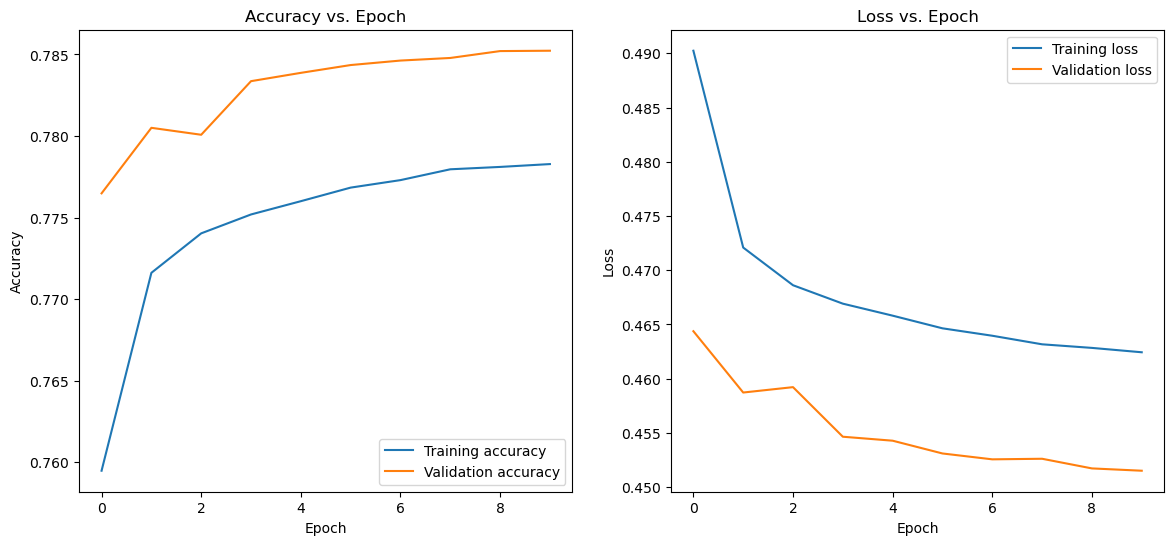

In [21]:
plot_performance(h1)
y_pred1 = model_report(rnn1, y_test)

#### 2.2.3 RNN 2

The second implementation of the GRU architecture uses a state size of 128

In [ ]:
rnn2 = Sequential([
    embedding_layer,
    GRU(128, dropout=0.2),
    Dense(128, activation="relu", kernel_initializer="he_normal"),
    Dropout(0.25),
    Dense(1, activation="sigmoid")
])

rnn2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
h2 = rnn2.fit(X_train, y_train, batch_size=128, epochs=20, validation_data=(X_test, y_test), verbose=0)

In [ ]:
plot_performance(h2)
y_pred2 = model_report(rnn2, y_test)

### 2.3 LSTM Architecture

In [ ]:
from keras.layers import LSTM

rnn3 = Sequential([
    embedding_layer,
    LSTM(64, dropout=0.2),
    Dense(64, activation="relu", kernel_initializer="he_normal"),
    Dropout(0.25),
    Dense(1, activation="sigmoid")
])

rnn3.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
h3 = rnn3.fit(X_train, y_train, batch_size=128, epochs=20, validation_data=(X_test, y_test), verbose=0)

In [ ]:
plot_performance(h3)
y_pred3 = model_report(rnn3, y_test)

In [ ]:
rnn4 = Sequential([
    embedding_layer,
    LSTM(128, dropout=0.2),
    Dense(128, activation="relu", kernel_initializer="he_normal"),
    Dropout(0.25),
    Dense(1, activation="sigmoid")
])

rnn4.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
h4 = rnn4.fit(X_train, y_train, batch_size=128, epochs=20, validation_data=(X_test, y_test), verbose=0)

In [ ]:
plot_performance(h4)
y_pred4 = model_report(rnn4, y_test)